# Sandbox for training a classifier on patient features to help enusre that feature extraction is working

In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
# import pickle
# import ieeg_funcs as ief
# import re
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import imp 
imp.reload(dg) 

<module 'dgFuncs' from '/home/dgroppe/GIT/DG_LIBRARY/dgFuncs.py'>

In [3]:
def chan_labels_from_fname(in_file):
    just_fname=in_file.split('/')[-1]
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [10]:
print(temp_ftrs.keys())
f

dict_keys(['__header__', '__version__', '__globals__', 'ftr_labels', 'source_fnames', 'subsamp_se_ftrs', 'subsamp_se_ftrs_time_sec', 'subsamp_szr_class', 'subsamp_targ_class'])


'1096_HL5_HL6_subsamp.mat'

In [12]:
sub='620'
sub='1096'
# Get size of non-szr data (and filename)
# Get filenames 
#/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096_HL1_HL2_non.mat
#ftr_path='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
ftr_path=os.path.join('/home/dgroppe/GIT/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE',sub)
non_fnames=list()
szr_fnames=list()
for f in os.listdir(ftr_path):
    if f.endswith('non.mat'):
        non_fnames.append(f)
    elif f.endswith('subsamp.mat'):
        pass
    elif f.endswith('.mat') and f.startswith(sub+'_'):
        szr_fnames.append(f)
        
print('%d non-szr files found' % len(non_fnames))
print('%d szr files found' % len(szr_fnames))  
    
# Import NON-szr files to get total # of windows
n_non_wind=0
ftr_dim=0
for f in non_fnames:
    in_file=os.path.join(ftr_path,f)
    temp_ftrs=sio.loadmat(in_file)
    n_non_wind+=temp_ftrs['nonszr_se_ftrs'].shape[1]
    if ftr_dim==0:
        ftr_dim=temp_ftrs['nonszr_se_ftrs'].shape[0]
print('%d total # of NON-szr time windows' % n_non_wind)

# Loop over SZR files to get total # of windows
n_szr_wind=0
for f in szr_fnames:
    in_file=os.path.join(ftr_path,f)
    temp_ftrs=sio.loadmat(in_file)
    #print(temp_ftrs.keys())
    n_szr_wind+=temp_ftrs['se_ftrs'].shape[1]
print('%d total # of SZR time windows' % n_szr_wind)
# print(temp_ftrs.keys())
#dict_keys(['__header__', '__version__', '__globals__', 'ftr_labels', 'nonszr_se_ftrs',
#           'nonszr_se_ftrs_time_sec', 'source_fnames'])

8 non-szr files found
38 szr files found
47190 total # of NON-szr time windows
46818 total # of SZR time windows


In [14]:
print(in_file)
temp_ftrs.keys()

/home/dgroppe/GIT/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/1096/1096_HL7_HL8_non.mat


dict_keys(['__header__', '__version__', '__globals__', 'ftr_labels', 'nonszr_se_ftrs', 'nonszr_se_ftrs_time_sec', 'source_fnames'])

In [13]:
# Preallocate memory
ftrs=np.zeros((ftr_dim,n_szr_wind+n_non_wind))
targ_labels=np.zeros(n_szr_wind+n_non_wind)

# Import non-szr data
ptr=0
mns_dict=dict()
sds_dict=dict()

in_file=os.path.join(ftr_path,non_fnames[0])
# chan_label=chan_labels_from_fname(in_file)
    
temp_ftrs=sio.loadmat(in_file)
# Get list of channels
n_chans=temp_ftrs['chan_labels'].shape[0]  
chan_labels=list()
for temp_lab in temp_ftrs['chan_labels']:
    chan_labels.append(temp_lab[0][0])

# Import features
non_n_wind=temp_ftrs['nonszr_se_ftrs'].shape[1]
raw_ftrs=temp_ftrs['nonszr_se_ftrs']    
n_ftrs=raw_ftrs.shape[0]
chan_mns=np.zeros((n_ftrs,n_chans))
chan_sds=np.zeros((n_ftrs,n_chans))
# Normalize features on a per-channel basis
for chan_id in range(n_chans):
#for chan_id in range(1,2):
    for ftr_id in range(n_ftrs):
        ftrs_for_this_chan=temp_ftrs['ftr_chan_map'][0,:]==(chan_id+1)
        chan_mns[ftr_id,chan_id]=np.mean(raw_ftrs[ftr_id,ftrs_for_this_chan])
        chan_sds[ftr_id,chan_id]=np.std(raw_ftrs[ftr_id,ftrs_for_this_chan])
#         raw_ftrs[ftr_id,ftrs_for_this_chan]=(raw_ftrs[ftr_id,ftrs_for_this_chan]-
#                                              chan_mns[ftr_id,chan_id])/chan_sds[ftr_id,chan_id]

# for t in range(non_n_wind):
#     chan_id=1
#     for ftr_id in range(n_ftrs):
#         raw_ftrs[ftr_id,t]=(raw_ftrs[ftr_id,t]-chan_mns[ftr_id,chan_id])/chan_sds[ftr_id,chan_id]
ftrs[:,:non_n_wind]=raw_ftrs


# Import szr data
ptr=non_n_wind
for f in szr_fnames:
    in_file=os.path.join(ftr_path,f)
    chan_label=chan_labels_from_fname(in_file)
    temp_ftrs=sio.loadmat(in_file)
    temp_n_wind=temp_ftrs['se_ftrs'].shape[1]
    raw_ftrs=temp_ftrs['se_ftrs']
    chan_id=chan_labels.index(chan_label)
#     for ftr_id in range(n_ftrs):
#         raw_ftrs[ftr_id,:]=(raw_ftrs[ftr_id,:]-chan_mns[ftr_id,chan_id])/chan_sds[ftr_id,chan_id]
        
    ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
    targ_labels[ptr:ptr+temp_n_wind]=1;
    ptr+=temp_n_wind
print('done.')

KeyError: 'chan_labels'

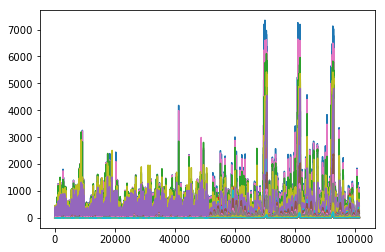

In [34]:
plt.figure(1)
plt.clf()
plt.plot(ftrs.T);
# plt.plot(temp_ftrs['ftr_chan_map'][0,:]*400,'r-')

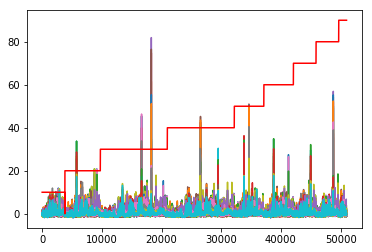

In [8]:
plt.figure(1)
plt.clf()
plt.plot(raw_ftrs.T);
plt.plot(temp_ftrs['ftr_chan_map'][0,:]*10,'r-')

# plt.figure(2)
# plt.clf()
# plt.plot(targ_labels);

In [7]:
temp_ftrs['ftr_chan_map'].shape

(1, 50986)

In [ ]:
print(in_file)
just_fname=in_file.split('/')[-1]
print(just_fname)
jf_splt=just_fname.split('_')
chan_label=jf_splt[1]+'-'+jf_splt[2]
print(chan_label)

In [ ]:
# Train classifier
C=1
model = linear_model.LogisticRegression(C=C,class_weight='balanced')

model.fit(ftrs.T, targ_labels)

# 

In [ ]:
train_class_hat = model.predict_proba(ftrs.T)[:,1]

In [ ]:
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(targ_labels, train_class_hat)
print('AUC=%.3f' % auc)

In [ ]:
plt.figure(11)
plt.clf()
plt.plot(ftrs.T);

plt.figure(12)
plt.clf()
plt.plot(targ_labels,'b-');
plt.plot(train_class_hat,'r-');

In [ ]:
print(temp_ftrs.keys())

In [ ]:
temp_ftrs['nonszr_se_ftrs'].shape[1]

In [35]:
from imblearn.under_sampling import ClusterCentroids

In [36]:
ClusterCentroids?

In [ ]:
# Train classifier


In [ ]:
# Predict data

In [ ]:
# Plot some szrs along with predictions?